In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

In [4]:
notebook = "real3_CalHousing"

In [5]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
ndpost = 100000
nskip = 0
n_trees = 100

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
proposal_probs_default = {
    'grow': 0.25,
    'prune': 0.25,
    'change': 0.4,
    'swap': 0.1
}
bart = DefaultBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_default, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_default.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_default.npy', np.array(rmses))

Iterations: 100%|██████████| 100000/100000 [2:22:39<00:00, 11.68it/s] 


In [11]:
proposal_probs_mtmh = {
    'multi_grow': 0.25,
    'multi_prune': 0.25,
    'multi_change': 0.4,
    'multi_swap': 0.1
}
bart = MultiBART(ndpost=ndpost, nskip=nskip, n_trees=n_trees,
                proposal_probs=proposal_probs_mtmh, multi_tries=10, random_state=0)
bart.fit(X_train, y_train)
sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
preds = bart.posterior_f(X_test, backtransform=True)
rmses = [root_mean_squared_error(y_test, preds[:, k]) for k in range(preds.shape[1])]

np.save(f'store/{notebook}_sigmas_mtmh.npy', np.array(sigmas))
np.save(f'store/{notebook}_rmses_mtmh.npy', np.array(rmses))

Iterations: 100%|██████████| 100000/100000 [10:39:40<00:00,  2.61it/s] 


In [9]:
from diagnosis import segmented_ljung_box_test, segment_ess_efficiency

## Default

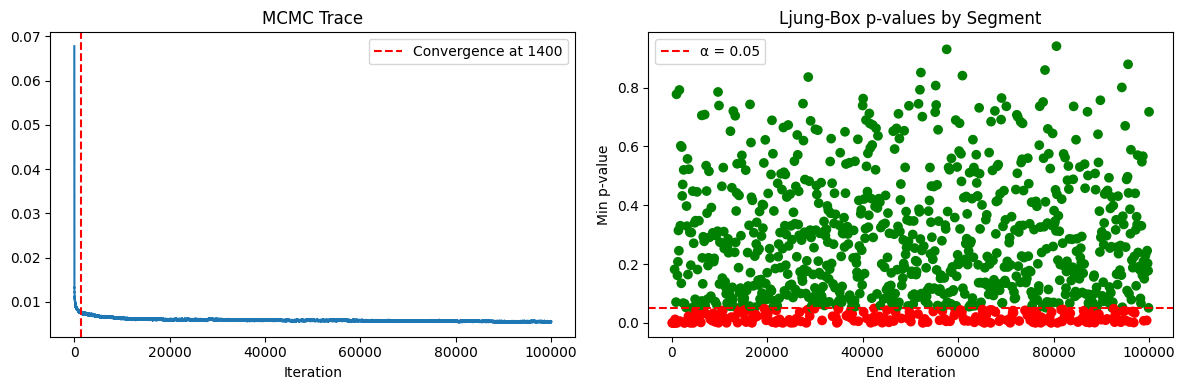

Chain converged: True
Convergence at iteration: 1400
Convergence rate: 78.20%


In [10]:
# Diagnose default sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

/nfs/home/svu/e0950116/bart-playground/diagnosis/diagnosis.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


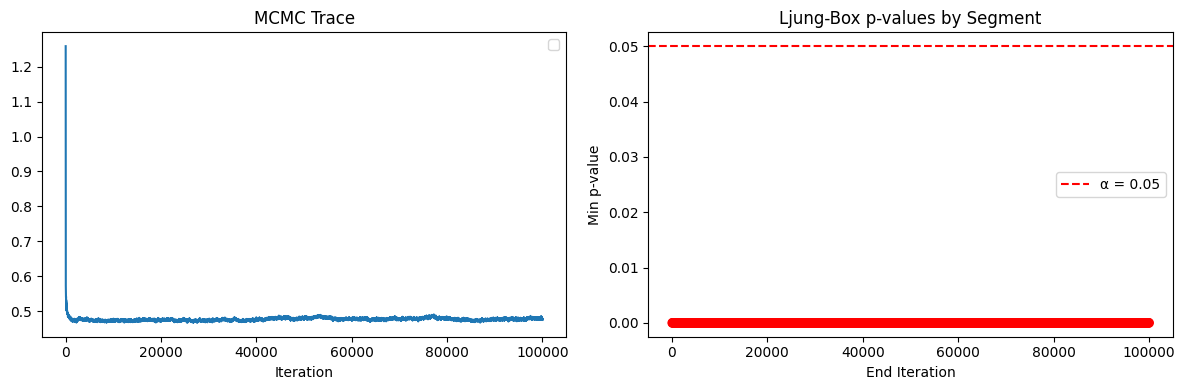

Chain converged: False
Convergence rate: 0.00%


In [11]:
# Diagnose default rmse convergence
rmses = np.load(f'store/{notebook}_rmses_default.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

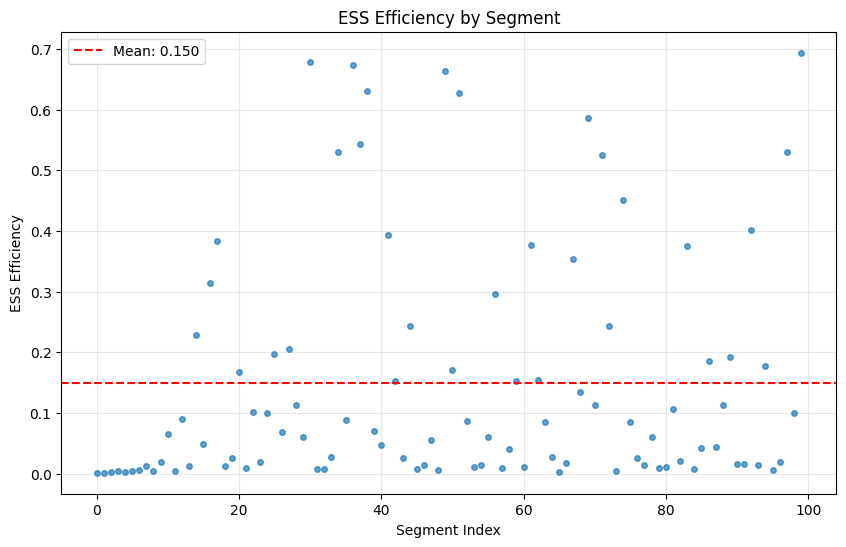

In [11]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=1000)

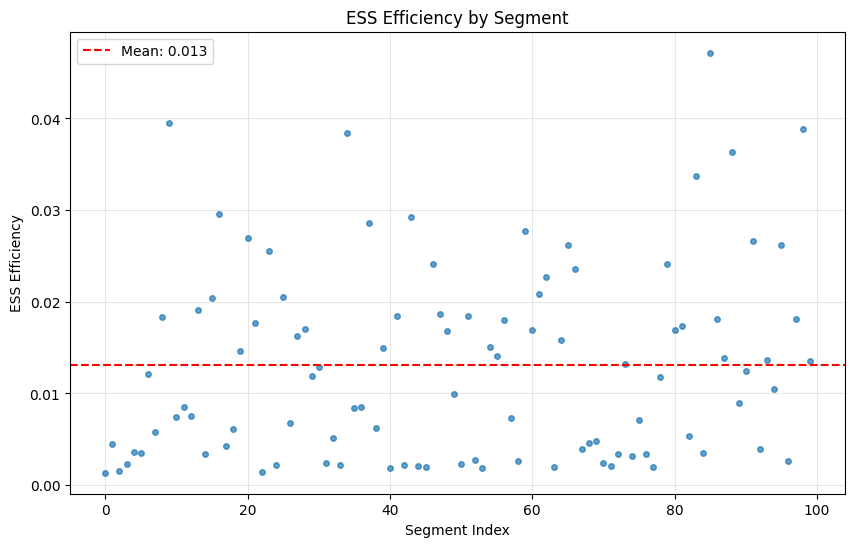

In [15]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=1000)

### Autocorrelation

In [9]:
from diagnosis import plot_autocorrelation

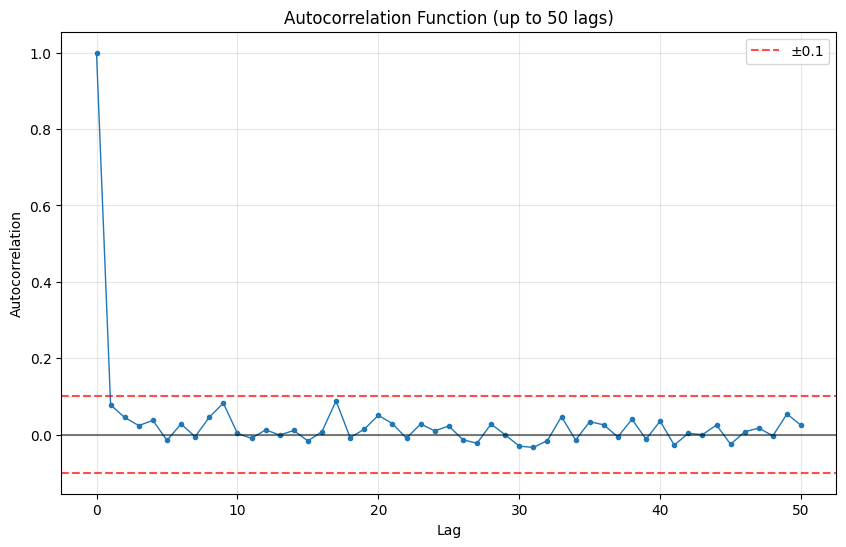

array([ 1.00000000e+00,  7.77621325e-02,  4.46418197e-02,  2.34754471e-02,
        3.70373406e-02, -1.51220657e-02,  2.75978834e-02, -5.56895030e-03,
        4.51458906e-02,  8.23925164e-02,  3.08028265e-03, -1.00202604e-02,
        1.23685981e-02, -1.32088844e-03,  1.07257175e-02, -1.67882792e-02,
        7.60308247e-03,  8.80421858e-02, -7.97407199e-03,  1.38451360e-02,
        5.04092513e-02,  2.86657274e-02, -9.72328254e-03,  2.78192849e-02,
        9.48198943e-03,  2.23852289e-02, -1.34028688e-02, -2.30134222e-02,
        2.74739661e-02, -6.49051708e-04, -3.03411029e-02, -3.37979427e-02,
       -1.58069978e-02,  4.70706024e-02, -1.46666403e-02,  3.36768077e-02,
        2.54072213e-02, -6.24907228e-03,  4.00978200e-02, -1.22678333e-02,
        3.51034570e-02, -2.76925786e-02,  3.30943025e-03, -5.56693098e-04,
        2.51071837e-02, -2.55392741e-02,  7.21673670e-03,  1.69997690e-02,
       -3.44244449e-03,  5.39682320e-02,  2.41256691e-02])

In [10]:
sigmas = np.load(f'store/{notebook}_sigmas_default.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

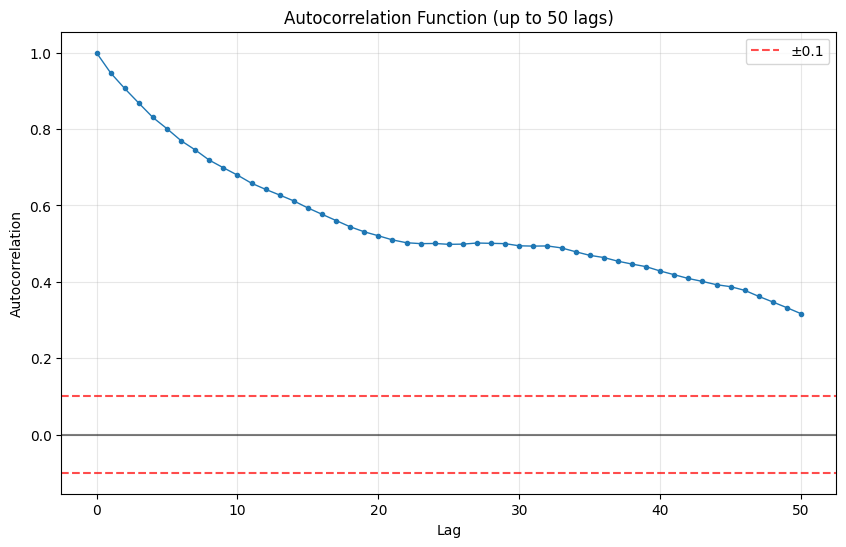

array([1.        , 0.94727303, 0.90637028, 0.86814345, 0.83051096,
       0.80106196, 0.76962414, 0.74559163, 0.71872572, 0.69883134,
       0.67952134, 0.65823405, 0.64215193, 0.62729109, 0.61188606,
       0.59347645, 0.57692686, 0.56050979, 0.54414653, 0.53096546,
       0.5206324 , 0.50977169, 0.50236657, 0.50000008, 0.50042182,
       0.49815575, 0.49870408, 0.50162649, 0.50076313, 0.49999433,
       0.49429506, 0.49353654, 0.49392942, 0.48880786, 0.47877726,
       0.4693677 , 0.46361663, 0.45403916, 0.44648882, 0.43969954,
       0.42835154, 0.4185732 , 0.40873005, 0.40103781, 0.39244625,
       0.38727641, 0.37768425, 0.36183609, 0.34710851, 0.33216371,
       0.31646706])

In [11]:
rmses = np.load(f'store/{notebook}_rmses_default.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)

## MTMH

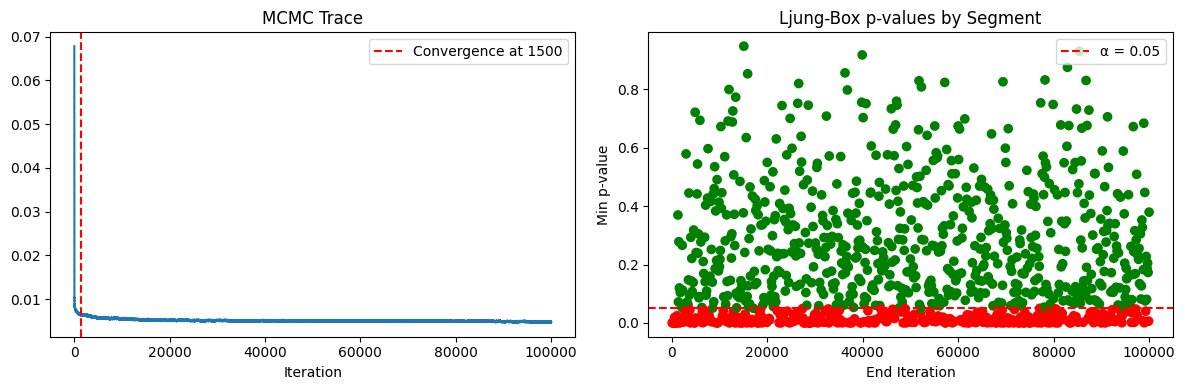

Chain converged: True
Convergence at iteration: 1500
Convergence rate: 67.70%


In [15]:
# Diagnose mtmh sigma convergence
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
convergence_result = segmented_ljung_box_test(sigmas, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

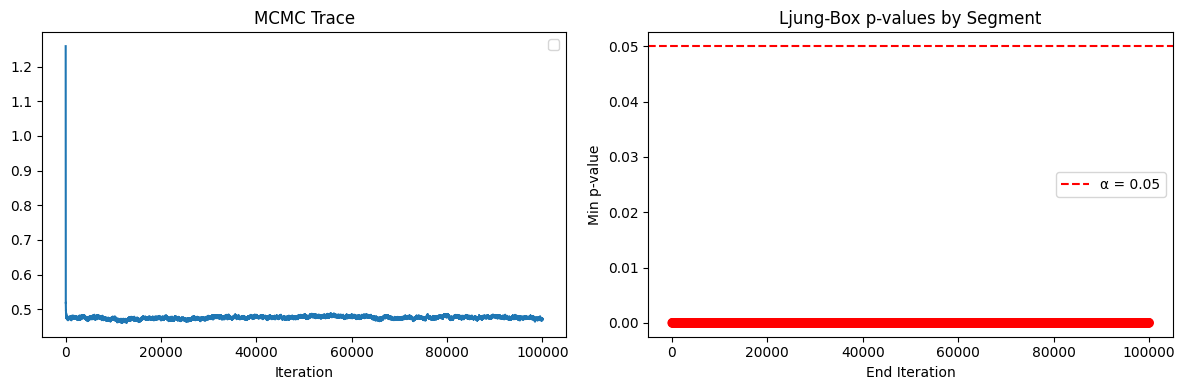

Chain converged: False
Convergence rate: 0.00%


In [16]:
# Diagnose mtmh rmse convergence
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
convergence_result = segmented_ljung_box_test(rmses, segment_length=100)

print(f"Chain converged: {convergence_result['converged']}")
if convergence_result['converged']:
    print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")

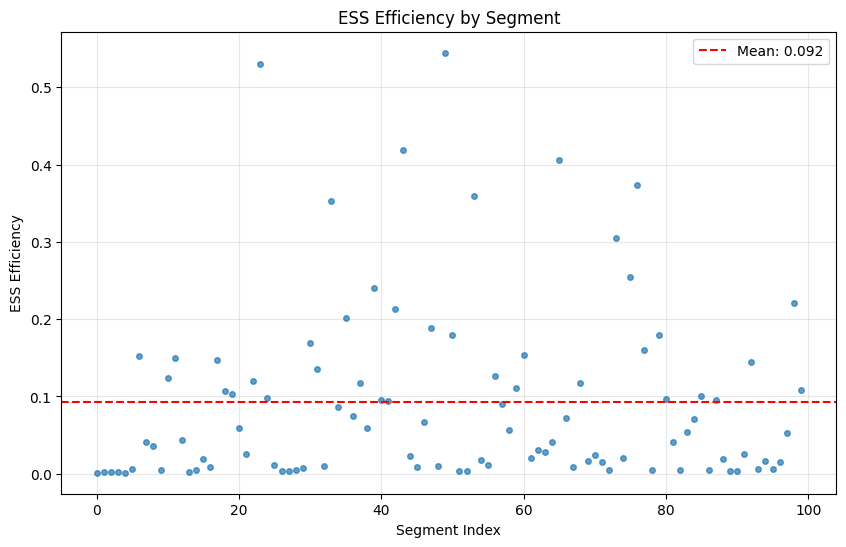

In [13]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
efficiencies = segment_ess_efficiency(sigmas, segment_length=1000)

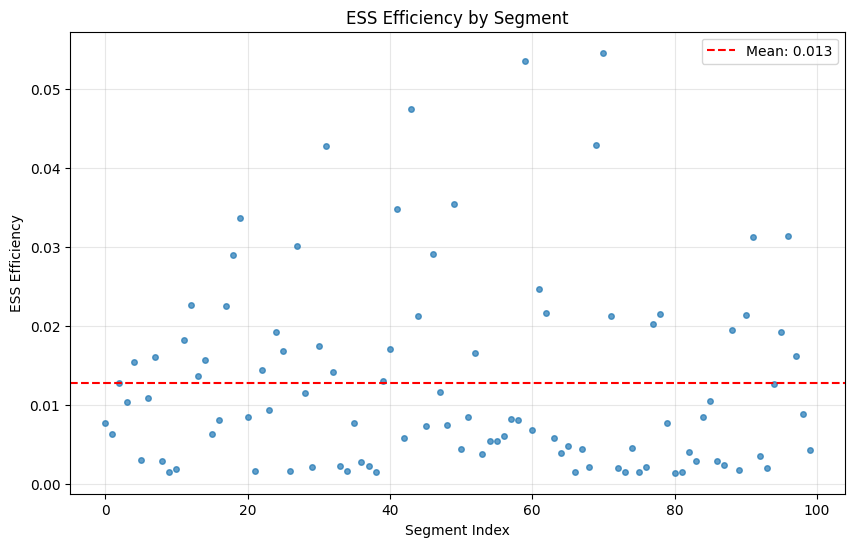

In [14]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
efficiencies = segment_ess_efficiency(rmses, segment_length=1000)

### Autocorrelation

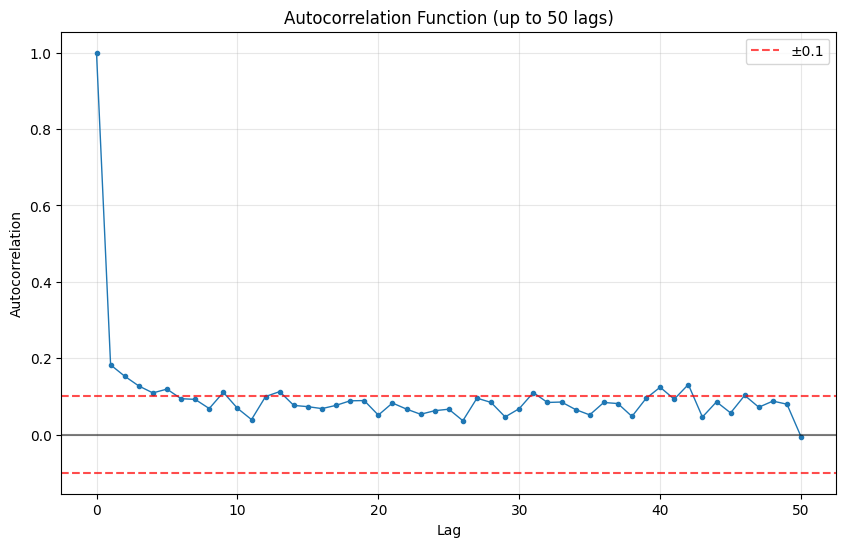

array([ 1.        ,  0.18245468,  0.15282488,  0.12726656,  0.10903942,
        0.11899069,  0.09389868,  0.09208108,  0.06810117,  0.11057574,
        0.06888403,  0.03917953,  0.09961663,  0.1124156 ,  0.07629748,
        0.07300727,  0.06792743,  0.07644529,  0.08836496,  0.08896723,
        0.05086637,  0.08257081,  0.06664106,  0.05312495,  0.06242894,
        0.06639498,  0.03621653,  0.09528463,  0.08412211,  0.04615945,
        0.0678149 ,  0.10989537,  0.08401836,  0.08514638,  0.06538753,
        0.05148036,  0.0839842 ,  0.08116445,  0.04743582,  0.09464122,
        0.12395901,  0.09257445,  0.13102331,  0.04584564,  0.08562746,
        0.05663158,  0.10254228,  0.07158841,  0.08758777,  0.07946662,
       -0.0056665 ])

In [12]:
sigmas = np.load(f'store/{notebook}_sigmas_mtmh.npy')
plot_autocorrelation(sigmas[-1000:], nlags=50)

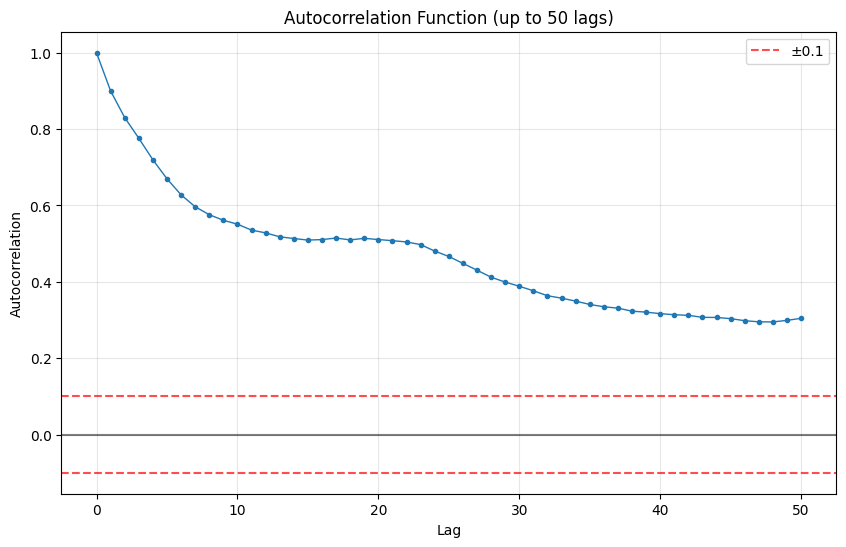

array([1.        , 0.89994647, 0.83016007, 0.77610821, 0.71954304,
       0.66992784, 0.62785126, 0.59666969, 0.57582015, 0.56118331,
       0.55093188, 0.53542085, 0.52818228, 0.51785128, 0.51341154,
       0.50927811, 0.51060807, 0.51461419, 0.5097663 , 0.51385229,
       0.51070429, 0.50772603, 0.50444769, 0.49741818, 0.48057128,
       0.46644644, 0.44830914, 0.43052981, 0.41209248, 0.39930604,
       0.38842174, 0.37653888, 0.36359588, 0.35723455, 0.3494944 ,
       0.34074364, 0.33462116, 0.33107008, 0.32312806, 0.32058955,
       0.31662726, 0.31382756, 0.31224105, 0.30692772, 0.3066623 ,
       0.30354504, 0.29819583, 0.29521425, 0.29491424, 0.29906255,
       0.30435437])

In [13]:
rmses = np.load(f'store/{notebook}_rmses_mtmh.npy')
plot_autocorrelation(rmses[-1000:], nlags=50)